In [17]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import cobaya # Not used in your working solution, but imported
import camb # Not used in your working solution, but imported

✅ Teste concluído com sucesso. Arquivo triangle_test_plot.png criado.


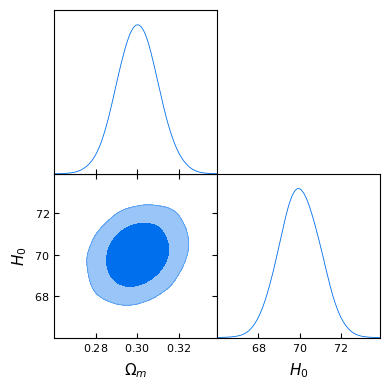

In [18]:
# test_cosmology.py
import numpy as np
import matplotlib.pyplot as plt
from getdist import plots, MCSamples

# Generate simulated data for testing (as if from an MCMC chain)
samples = np.random.multivariate_normal(
    mean=[0.3, 70],
    cov=[[0.01**2, 0.002], [0.002, 1.0**2]],
    size=10000
)

# Create an MCSamples object for use with GetDist
names = ["omega_m", "H0"]
labels = ["\\Omega_m", "H_0"] # SyntaxWarning: invalid escape sequence '\\O', should be r"\Omega_m"
mcmc_samples = MCSamples(samples=samples, names=names, labels=labels)

# Plot the results
g = plots.get_subplot_plotter()
g.triangle_plot(mcmc_samples, filled=True)

# Save the plot as an image
plt.savefig("triangle_test_plot.png")
print("✅ Teste concluído com sucesso. Arquivo triangle_test_plot.png criado.")

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee
import corner

# -----------------------------
# 1. Load the Pantheon+ Data
# -----------------------------
# Use a raw string for the separator to avoid SyntaxWarning
df = pd.read_csv("Pantheon+SH0ES.dat", sep=r'\s+', comment='#')
print(f"Initial Pantheon+ data loaded: {len(df)} entries.")

# Filter: Use only Hubble-flow supernovae
# Importantly, we store the ORIGINAL indices before resetting.
# The `USED_IN_SH0ES_HF` column is a binary indicator.
original_full_df_indices = df[df['USED_IN_SH0ES_HF'] == 1].index.values
df_filtered = df[df['USED_IN_SH0ES_HF'] == 1].reset_index(drop=True)
print(f"Filtered to Hubble Flow SNe: {len(df_filtered)} entries.")

z = df_filtered['zHD'].values
mu_obs = df_filtered['MU_SH0ES'].values

# -----------------------------
# 2. Load and reshape covariance matrix
# -----------------------------
with open("Pantheon+SH0ES_STAT+SYS.cov") as f: # Use the full covariance matrix
    N = int(f.readline())  # N should be 1701 for the full matrix
    flat_cov = np.loadtxt(f)
    cov_all = flat_cov.reshape((N, N))

# Crucial step: Subset the covariance matrix using the ORIGINAL indices
# that correspond to the filtered Hubble-flow supernovae.
cov = cov_all[np.ix_(original_full_df_indices, original_full_df_indices)]

# Add a small diagonal term (jitter) for numerical stability.
# This helps with near-singular matrices, though a truly singular matrix
# indicates a deeper problem. Let's try it first.
jitter = 1e-9 * np.eye(cov.shape[0])
inv_cov = np.linalg.inv(cov + jitter)
print("Covariance matrix inverted successfully.")

# -----------------------------
# 3. Cosmological model (flat ΛCDM)
# -----------------------------
def luminosity_distance(z, H0, Omega_m):
    c = 299792.458  # speed of light in km/s
    # E(z) for flat LambdaCDM
    def E_inv(z_prime): return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))
    integral = np.array([quad(E_inv, 0, zi)[0] for zi in z])
    dL = (c / H0) * (1 + z) * integral  # in Mpc
    return dL

def distance_modulus(z, H0, Omega_m):
    dL = luminosity_distance(z, H0, Omega_m)
    # Adding a small epsilon to dL before log10 to prevent log(0) for extreme values
    return 5 * np.log10(dL + 1e-10) + 25

# -----------------------------
# 4. Log-likelihood function
# -----------------------------\
# We're already using MU_SH0ES, which implies M has been calibrated from SH0ES Cepheids.
# So, we don't need to marginalize over M. The MU_SH0ES values are already "standardized".
def log_likelihood(theta):
    H0, Omega_m = theta
    # Define tighter prior bounds to help MCMC exploration and avoid problematic regions
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8): # Relaxed Omega_m upper bound slightly
        return -np.inf  # Parameters outside prior bounds
    
    # Calculate theoretical distance modulus
    mu_th = distance_modulus(z, H0, Omega_m)
    
    # Calculate residuals
    delta = mu_obs - mu_th
    
    # Compute chi-squared
    chi2 = delta @ inv_cov @ delta
    
    # Return log-likelihood (note the -0.5 factor for chi2)
    return -0.5 * chi2

# -----------------------------
# 5. MCMC setup
# -----------------------------
ndim = 2          # H0, Omega_m
nwalkers = 32     # Number of parallel chains/walkers
nsteps = 5000     # Total number of steps per walker
burn_in = 1000    # Steps to discard for burn-in
thin_factor = 10  # Thinning factor for samples

# Initial positions for walkers, perturbed around a central guess
initial_guess = np.array([70.0, 0.3])
pos = initial_guess + 1e-3 * np.random.randn(nwalkers, ndim) # Smaller perturbation

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
print("🔁 Running MCMC...")
sampler.run_mcmc(pos, nsteps, progress=True)
print("✅ MCMC completed!")

# -----------------------------
# 6. Process and Plot Posterior
# -----------------------------
samples = sampler.get_chain(discard=burn_in, thin=thin_factor, flat=True)

# Print shape of processed samples to verify
print(f"Shape of processed samples (after burn-in and thinning): {samples.shape}")

fig = corner.corner(samples, labels=[r"$H_0$", r"$\Omega_m$"], # Corrected LaTeX syntax
                    truths=[70, 0.3], # Keep as reference
                    show_titles=True, title_fmt=".2f", quantiles=[0.16, 0.5, 0.84]) # Show median and 68%
plt.savefig("pantheon_mcmc_corner.png")
plt.show()

# Print best-fit values (median and 68% credible intervals)
h0_mcmc = np.percentile(samples[:, 0], [16, 50, 84])
omega_m_mcmc = np.percentile(samples[:, 1], [16, 50, 84])

print(f"\n📊 Best-fit H0 = {h0_mcmc[1]:.2f} +{h0_mcmc[2]-h0_mcmc[1]:.2f} -{h0_mcmc[1]-h0_mcmc[0]:.2f} km/s/Mpc")
print(f"📊 Best-fit Omega_m = {omega_m_mcmc[1]:.3f} +{omega_m_mcmc[2]-omega_m_mcmc[1]:.3f} -{omega_m_mcmc[1]-omega_m_mcmc[0]:.3f}")

# Optional: Basic check of chain length and acceptance fraction
print(f"\nAverage acceptance fraction: {np.mean(sampler.acceptance_fraction):.2f}")
print(f"Total number of samples in chain: {nwalkers * nsteps}")
print(f"Number of samples after burn-in and thinning: {samples.shape[0]}")

Initial Pantheon+ data loaded: 1701 entries.
Filtered to Hubble Flow SNe: 277 entries.
Covariance matrix inverted successfully.
🔁 Running MCMC...


  1%|▏         | 63/5000 [00:18<24:00,  3.43it/s]Traceback (most recent call last):
  File "C:\Users\GuilhermedeSouzaFern\anaconda3\Lib\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GuilhermedeSouzaFern\AppData\Local\Temp\ipykernel_10140\529444561.py", line 72, in log_likelihood
    mu_th = distance_modulus(z, H0, Omega_m)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GuilhermedeSouzaFern\AppData\Local\Temp\ipykernel_10140\529444561.py", line 56, in distance_modulus
    dL = luminosity_distance(z, H0, Omega_m)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GuilhermedeSouzaFern\AppData\Local\Temp\ipykernel_10140\529444561.py", line 51, in luminosity_distance
    integral = np.array([quad(E_inv, 0, zi)[0] for zi in z])
                         ^^^^^^^^^^^^^^^^^^
  File "C:\Users\GuilhermedeSouzaFern\anaconda3\Lib\site-packages\scipy\int

emcee: Exception while calling your likelihood function:
  params: [73.30025453  0.16768415]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

<>:16: SyntaxWarning: invalid escape sequence '\L'
<>:16: SyntaxWarning: invalid escape sequence '\O'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\L'
<>:16: SyntaxWarning: invalid escape sequence '\O'
<>:19: SyntaxWarning: invalid escape sequence '\m'
C:\Users\GuilhermedeSouzaFern\AppData\Local\Temp\ipykernel_10140\4047456701.py:16: SyntaxWarning: invalid escape sequence '\L'
  plt.plot(z, mu_fid, 'r--', label=f'Flat $\Lambda$CDM (H$_0$={H0_fid}, $\Omega_m$={Omega_m_fid})')
C:\Users\GuilhermedeSouzaFern\AppData\Local\Temp\ipykernel_10140\4047456701.py:16: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(z, mu_fid, 'r--', label=f'Flat $\Lambda$CDM (H$_0$={H0_fid}, $\Omega_m$={Omega_m_fid})')
C:\Users\GuilhermedeSouzaFern\AppData\Local\Temp\ipykernel_10140\4047456701.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Distance Modulus ($\mu$)')


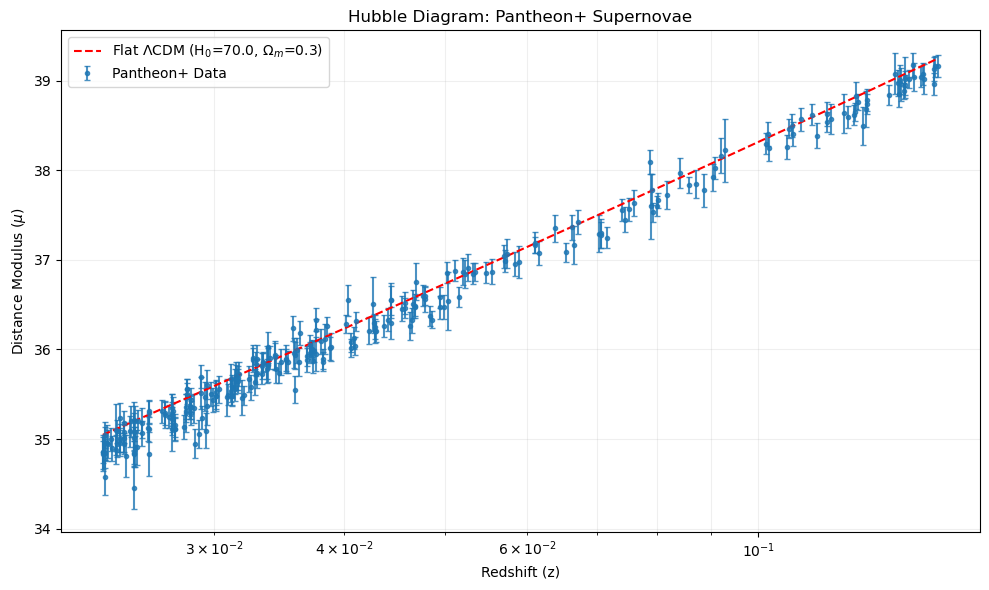

✅ Raw Hubble Diagram plot created.


In [34]:
# New Cell: Plotting Raw Pantheon+ Data (Hubble Diagram)

import matplotlib.pyplot as plt
import numpy as np # Already imported, but good practice for standalone cells

# Ensure z and mu_obs are available from the data loading section
# (These variables are defined in the MCMC script cell, so run that cell first if you're running this new cell independently)

plt.figure(figsize=(10, 6)) # Set figure size
plt.errorbar(z, mu_obs, yerr=np.sqrt(np.diag(cov)), fmt='.', capsize=2, alpha=0.8, label='Pantheon+ Data')

# Optional: Plot a fiducial LambdaCDM model as a reference
H0_fid = 70.0
Omega_m_fid = 0.3
mu_fid = distance_modulus(z, H0_fid, Omega_m_fid) # Reuse your defined function
plt.plot(z, mu_fid, 'r--', label=f'Flat $\Lambda$CDM (H$_0$={H0_fid}, $\Omega_m$={Omega_m_fid})')

plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.title('Hubble Diagram: Pantheon+ Supernovae')
plt.xscale('log') # Redshift is often plotted on a log scale
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.savefig("pantheon_raw_hubble_diagram.png")
plt.show()

print("✅ Raw Hubble Diagram plot created.")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee
import corner

# -----------------------------
# 1. Load DESI BAO Data
# -----------------------------
# Path to your DESI BAO mean and covariance files
desi_mean_file = "desi_2024_gaussian_bao_ALL_GCcomb_mean.txt"
desi_cov_file = "desi_2024_gaussian_bao_ALL_GCcomb_cov.txt"

# Load mean values
desi_data_raw = pd.read_csv(desi_mean_file, sep=r'\s+', comment='#', header=None,
                            names=['z_eff', 'value', 'quantity_type'])
print(f"DESI BAO data loaded: {len(desi_data_raw)} entries.")

z_eff_desi = desi_data_raw['z_eff'].values
observed_values_desi = desi_data_raw['value'].values
quantity_types_desi = desi_data_raw['quantity_type'].values

# Load covariance matrix
cov_desi_flat = np.loadtxt(desi_cov_file)
# The covariance matrix is a square matrix, its size is the number of observed quantities
N_desi = len(observed_values_desi)
cov_desi = cov_desi_flat.reshape((N_desi, N_desi))

# Add a small jitter for numerical stability during inversion, just like with Pantheon+
jitter_desi = 1e-9 * np.eye(cov_desi.shape[0])
inv_cov_desi = np.linalg.inv(cov_desi + jitter_desi)
print("DESI BAO Covariance matrix inverted successfully.")

# -----------------------------
# 2. Cosmological Model Functions for BAO
#    (Adapting and extending previous functions)
# -----------------------------

# Assuming a flat LambdaCDM model for these functions
# H0, Omega_m are passed as arguments
# Other cosmological parameters (like ombh2, Neff) are fixed for now for r_d calculation.

# Speed of light (already defined, ensure 'c' is accessible or re-define)
c = 299792.458 # km/s

def H_z(z_val, H0, Omega_m):
    # E(z) for flat LambdaCDM is sqrt(Omega_m*(1+z)^3 + (1-Omega_m))
    return H0 * np.sqrt(Omega_m * (1 + z_val)**3 + (1 - Omega_m))

def D_H_th(z_val, H0, Omega_m):
    # Hubble Distance: c / H(z)
    return c / H_z(z_val, H0, Omega_m)

def D_M_th(z_val, H0, Omega_m):
    # Transverse Comoving Distance: (c/H0) * integral(dz'/E(z'))
    # Reuse integral part, ensuring E_inv is based on H0 and Omega_m
    def E_inv_for_DM(z_prime): return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))
    
    # quad function can handle single values for z, or np.vectorize for arrays
    if isinstance(z_val, np.ndarray):
        integral = np.array([quad(E_inv_for_DM, 0, zi)[0] for zi in z_val])
    else: # Handle single z value if passed
        integral = quad(E_inv_for_DM, 0, z_val)[0]
        
    return (c / H0) * integral

def D_V_th(z_val, H0, Omega_m):
    # Volume-averaged distance: (z * D_M(z)^2 * D_H(z))^(1/3)
    dm_val = D_M_th(z_val, H0, Omega_m)
    dh_val = D_H_th(z_val, H0, Omega_m)
    return (z_val * dm_val**2 * dh_val)**(1/3.0)

# Theoretical Sound Horizon (r_d)
# This formula is from DESI BAO paper
# Fixed values:
ombh2_fixed = 0.02237  # Planck 2018 value for Omega_b h^2
Neff_fixed = 3.044     # Standard effective number of relativistic species

def r_d_th(H0, Omega_m):
    h = H0 / 100.0
    omch2 = Omega_m * h**2 - ombh2_fixed # Omega_c h^2
    # Ensure omch2 is not negative, it's a density
    if omch2 <= 0:
        return -np.inf # Return negative inf, indicating an unphysical parameter combination
        
    # Full matter density (Omega_m h^2)
    omegamh2 = Omega_m * h**2 
    
    rd = 147.05 * (ombh2_fixed / 0.02236)**(-0.13) * \
         (omegamh2 / 0.1432)**(-0.23) * \
         (Neff_fixed / 3.04)**(-0.1)
    return rd

# -----------------------------
# 3. Log-likelihood function for DESI BAO
# -----------------------------
def log_likelihood_desi(theta):
    H0, Omega_m = theta
    
    # Priors for H0 and Omega_m (similar to Pantheon+, adjust if needed)
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8):
        return -np.inf 
        
    rd_model = r_d_th(H0, Omega_m)
    if rd_model == -np.inf: # Check for unphysical r_d_th from omch2 <= 0
        return -np.inf

    predicted_values_list = []
    for i, quantity_type in enumerate(quantity_types_desi):
        z = z_eff_desi[i] # Get the effective redshift for this measurement
        
        if quantity_type == 'DV_over_rs':
            val = D_V_th(z, H0, Omega_m) / rd_model
        elif quantity_type == 'DM_over_rs':
            val = D_M_th(z, H0, Omega_m) / rd_model
        elif quantity_type == 'DH_over_rs':
            val = D_H_th(z, H0, Omega_m) / rd_model
        else:
            # Should not happen if data is correctly structured
            return -np.inf # Unknown quantity type
        
        predicted_values_list.append(val)
        
    predicted_values_desi = np.array(predicted_values_list)
    
    delta_desi = observed_values_desi - predicted_values_desi
    
    chi2_desi = delta_desi @ inv_cov_desi @ delta_desi
    
    return -0.5 * chi2_desi

# -----------------------------
# 4. MCMC setup for DESI BAO
# -----------------------------
ndim_desi = 2          # H0, Omega_m
nwalkers_desi = 32
nsteps_desi = 5000     # Set to a reasonable number for first test
burn_in_desi = 1000
thin_factor_desi = 10

initial_guess_desi = np.array([68.0, 0.3]) # DESI paper favors lower H0, slightly lower Omega_m
pos_desi = initial_guess_desi + 1e-3 * np.random.randn(nwalkers_desi, ndim_desi)

sampler_desi = emcee.EnsembleSampler(nwalkers_desi, ndim_desi, log_likelihood_desi)

print("🔁 Running MCMC for DESI BAO...")
sampler_desi.run_mcmc(pos_desi, nsteps_desi, progress=True)
print("✅ MCMC for DESI BAO completed!")

# -----------------------------
# 5. Process and Plot Posterior for DESI BAO
# -----------------------------
samples_desi = sampler_desi.get_chain(discard=burn_in_desi, thin=thin_factor_desi, flat=True)

print(f"Shape of processed DESI samples: {samples_desi.shape}")

fig_desi = corner.corner(samples_desi, labels=[r"$H_0$", r"$\Omega_m$"],
                       truths=[68.0, 0.3], # Use the initial guess as a reference
                       show_titles=True, title_fmt=".2f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("desi_mcmc_corner.png")
plt.show()

# Print best-fit values
h0_desi_mcmc = np.percentile(samples_desi[:, 0], [16, 50, 84])
omega_m_desi_mcmc = np.percentile(samples_desi[:, 1], [16, 50, 84])

print(f"\n📊 DESI BAO Best-fit H0 = {h0_desi_mcmc[1]:.2f} +{h0_desi_mcmc[2]-h0_desi_mcmc[1]:.2f} -{h0_desi_mcmc[1]-h0_desi_mcmc[0]:.2f} km/s/Mpc")
print(f"📊 DESI BAO Best-fit Omega_m = {omega_m_desi_mcmc[1]:.3f} +{omega_m_desi_mcmc[2]-omega_m_desi_mcmc[1]:.3f} -{omega_m_desi_mcmc[1]-omega_m_desi_mcmc[0]:.3f}")

print(f"\nAverage DESI BAO acceptance fraction: {np.mean(sampler_desi.acceptance_fraction):.2f}")
print(f"Total DESI BAO samples in chain: {nwalkers_desi * nsteps_desi}")
print(f"Number of processed DESI BAO samples: {samples_desi.shape[0]}")

In [ ]:
# New Cell: Plotting Raw DESI BAO Data (Corrected)

import matplotlib.pyplot as plt
import numpy as np
# Ensure z_eff_desi, observed_values_desi, quantity_types_desi, cov_desi
# and cosmological model functions (H_z, D_H_th, D_M_th, D_V_th, r_d_th)
# are defined and accessible from the previous DESI MCMC cell.

# Define the best-fit parameters from your DESI-only run as a fiducial model
H0_desi_best = 68.95
Omega_m_desi_best = 0.295

# Function to get theoretical BAO predictions for plotting
def get_theoretical_bao_predictions(z_eff_arr, quantity_types_arr, H0, Omega_m):
    rd_model = r_d_th(H0, Omega_m)
    
    if rd_model == -np.inf: # Handle unphysical r_d_th if omch2 was negative
        return np.full_like(z_eff_arr, np.nan) # Return NaNs for plotting if unphysical

    predicted_values = []
    for i, quantity_type in enumerate(quantity_types_arr):
        z = z_eff_arr[i]
        
        if quantity_type == 'DV_over_rs':
            val = D_V_th(z, H0, Omega_m) / rd_model
        elif quantity_type == 'DM_over_rs':
            val = D_M_th(z, H0, Omega_m) / rd_model
        elif quantity_type == 'DH_over_rs':
            val = D_H_th(z, H0, Omega_m) / rd_model
        else:
            val = np.nan # Unknown quantity type
        
        predicted_values.append(val)
    return np.array(predicted_values)


# Calculate theoretical predictions for the best-fit model
predicted_values_desi_best_fit = get_theoretical_bao_predictions(
    z_eff_desi, quantity_types_desi, H0_desi_best, Omega_m_desi_best
)

# Extract errors from the diagonal of the covariance matrix
desi_errors = np.sqrt(np.diag(cov_desi))

# Create the plot
plt.figure(figsize=(10, 7))

# Set to keep track of labels already added to the legend
labels_added = set()

# Plot each data point with its error
for i in range(len(z_eff_desi)):
    z_val = z_eff_desi[i]
    obs_val = observed_values_desi[i]
    err_val = desi_errors[i]
    qty_type = quantity_types_desi[i]
    
    marker = 'o'
    color = 'blue'
    label_prefix = ""

    if qty_type == 'DV_over_rs':
        marker = 's' # Square for DV
        color = 'red'
        label_text = r'$D_V/r_s$ Data'
    elif qty_type == 'DM_over_rs':
        marker = 'o' # Circle for DM
        color = 'green'
        label_text = r'$D_M/r_s$ Data'
    elif qty_type == 'DH_over_rs':
        marker = '^' # Triangle up for DH
        color = 'purple'
        label_text = r'$D_H/r_s$ Data'
    else:
        label_text = "Unknown Data"
        
    # Add label only if it hasn't been added before
    if label_text not in labels_added:
        plt.errorbar(z_val, obs_val, yerr=err_val, fmt=marker, color=color, capsize=3, label=label_text)
        labels_added.add(label_text)
    else:
        plt.errorbar(z_val, obs_val, yerr=err_val, fmt=marker, color=color, capsize=3)

# Plot the theoretical best-fit curve for each quantity type
# It's better to plot continuous curves by creating a finer z grid
z_plot = np.linspace(0.1, 2.5, 100) # Fine grid for plotting

# Theoretical curves for DV/rs, DM/rs, DH/rs
rd_plot_model = r_d_th(H0_desi_best, Omega_m_desi_best)

# Handle cases where rd_plot_model is -np.inf from r_d_th check
if rd_plot_model == -np.inf:
    dv_over_rs_plot = np.full_like(z_plot, np.nan)
    dm_over_rs_plot = np.full_like(z_plot, np.nan)
    dh_over_rs_plot = np.full_like(z_plot, np.nan)
else:
    dv_over_rs_plot = np.array([D_V_th(z, H0_desi_best, Omega_m_desi_best) / rd_plot_model for z in z_plot])
    dm_over_rs_plot = np.array([D_M_th(z, H0_desi_best, Omega_m_desi_best) / rd_plot_model for z in z_plot])
    dh_over_rs_plot = np.array([D_H_th(z, H0_desi_best, Omega_m_desi_best) / rd_plot_model for z in z_plot])


plt.plot(z_plot, dv_over_rs_plot, 'r--', linewidth=1.5, label=r'Best-fit $\Lambda$CDM ($D_V/r_s$)')
plt.plot(z_plot, dm_over_rs_plot, 'g--', linewidth=1.5, label=r'Best-fit $\Lambda$CDM ($D_M/r_s$)')
plt.plot(z_plot, dh_over_rs_plot, 'p--', linewidth=1.5, label=r'Best-fit $\Lambda$CDM ($D_H/r_s$)') # Using 'p-' for purple dashed

plt.xlabel(r'Effective Redshift ($z_{eff}$)')
plt.ylabel(r'Distance Ratio (D/r$_s$)')
plt.title(r'DESI BAO Measurements and Best-fit $\Lambda$CDM Model')
plt.xscale('log') 
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend(fontsize='small', loc='lower right')
plt.tight_layout()
plt.savefig("desi_raw_bao_data.png")
plt.show()

print("✅ DESI BAO Raw Data plot created.")

In [ ]:
# New Cell: Combined Pantheon+ and DESI BAO Analysis

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# -----------------------------
# 1. Combined Log-likelihood function
# -----------------------------
def log_likelihood_combined(theta):
    # Calculate Pantheon+ log-likelihood
    lp_pantheon = log_likelihood(theta)
    
    # If Pantheon+ likelihood is -inf (parameters outside its prior), no need to calculate DESI
    if not np.isfinite(lp_pantheon):
        return -np.inf
        
    # Calculate DESI BAO log-likelihood
    lp_desi = log_likelihood_desi(theta)
    
    # If DESI likelihood is -inf (parameters outside its prior), no need to sum
    if not np.isfinite(lp_desi):
        return -np.inf
        
    # Sum the log-likelihoods for independent datasets
    return lp_pantheon + lp_desi

# -----------------------------
# 2. MCMC setup for Combined Data
# -----------------------------
ndim_combined = 2          # H0, Omega_m
nwalkers_combined = 32
nsteps_combined = 10000    # Increased steps for a potentially more complex posterior
burn_in_combined = 2000    # Increased burn-in
thin_factor_combined = 10

# A good initial guess can be the average of individual best-fits
# or slightly adjust towards the expected combined result.
# DESI: H0 ~68.95, Omega_m ~0.295
# Pantheon+: H0 ~73.14, Omega_m ~0.364
# Combined results are expected to be tighter and between the two.
initial_guess_combined = np.array([70.0, 0.32]) 
pos_combined = initial_guess_combined + 1e-3 * np.random.randn(nwalkers_combined, ndim_combined)

sampler_combined = emcee.EnsembleSampler(nwalkers_combined, ndim_combined, log_likelihood_combined)

print("🔁 Running MCMC for Combined Pantheon+ & DESI BAO data...")
sampler_combined.run_mcmc(pos_combined, nsteps_combined, progress=True)
print("✅ MCMC for Combined data completed!")

# -----------------------------
# 3. Process and Plot Posterior for Combined Data
# -----------------------------
samples_combined = sampler_combined.get_chain(discard=burn_in_combined, thin=thin_factor_combined, flat=True)

print(f"Shape of processed Combined samples: {samples_combined.shape}")

fig_combined = corner.corner(samples_combined, labels=[r"$H_0$", r"$\Omega_m$"],
                            truths=initial_guess_combined, # Use initial guess as a visual reference
                            show_titles=True, title_fmt=".2f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("combined_mcmc_corner.png")
plt.show()

# Print best-fit values
h0_combined_mcmc = np.percentile(samples_combined[:, 0], [16, 50, 84])
omega_m_combined_mcmc = np.percentile(samples_combined[:, 1], [16, 50, 84])

print(f"\n📊 Combined Best-fit H0 = {h0_combined_mcmc[1]:.2f} +{h0_combined_mcmc[2]-h0_combined_mcmc[1]:.2f} -{h0_combined_mcmc[1]-h0_combined_mcmc[0]:.2f} km/s/Mpc")
print(f"📊 Combined Best-fit Omega_m = {omega_m_combined_mcmc[1]:.3f} +{omega_m_combined_mcmc[2]-omega_m_combined_mcmc[1]:.3f} -{omega_m_combined_mcmc[1]-omega_m_combined_mcmc[0]:.3f}")

print(f"\nAverage Combined acceptance fraction: {np.mean(sampler_combined.acceptance_fraction):.2f}")
print(f"Total Combined samples in chain: {nwalkers_combined * nsteps_combined}")
print(f"Number of processed Combined samples: {samples_combined.shape[0]}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# -----------------------------
# 0. Define Assumed Omega_m
# -----------------------------
OMEGA_M_ASSUMED = 0.299 # Assumed fixed value for Omega_m

# Ensure fundamental constants/functions are accessible
c = 299792.458 # km/s (speed of light)
Neff_fixed = 3.044 # Standard effective number of relativistic species (fixed)

# -----------------------------
# 1. Updated Theoretical Sound Horizon (r_d) for fixed Omega_m
#    Now takes Omega_b as a parameter, and assumes Omega_m_fixed.
# -----------------------------
def r_d_th_for_fixed_Om(H0, Omega_b):
    h = H0 / 100.0
    ombh2_calc = Omega_b * h**2 # Calculate Omega_b h^2 dynamically

    # Calculate omch2 based on assumed Omega_m
    omch2_calc = OMEGA_M_ASSUMED * h**2 - ombh2_calc 

    # Priors for ombh2_calc and omch2_calc based on their physical meaning
    if not (ombh2_calc > 0.005 and omch2_calc > 0): # Adjusted prior for ombh2, omch2 > 0
        return -np.inf 
        
    # Full matter density (Omega_m h^2) derived from assumed Omega_m
    omegamh2_calc = OMEGA_M_ASSUMED * h**2 
    
    if not (omegamh2_calc > 0):
        return -np.inf

    # DESI BAO paper r_d formula
    rd = 147.05 * (ombh2_calc / 0.02236)**(-0.13) * \
         (omegamh2_calc / 0.1432)**(-0.23) * \
         (Neff_fixed / 3.04)**(-0.1)
    return rd

# -----------------------------
# 2. Updated Log-likelihood function for DESI BAO (for fixed Omega_m)
#    Now takes H0, Omega_b as parameters.
# -----------------------------
def log_likelihood_desi_for_fixed_Om(theta_desi):
    H0, Omega_b = theta_desi # Only H0 and Omega_b are sampled
    
    # Priors for H0 and Omega_b
    if not (55 < H0 < 90 and 0.03 < Omega_b < 0.06): 
        return -np.inf 
        
    # Use the updated r_d_th function that takes fixed Omega_m
    rd_model = r_d_th_for_fixed_Om(H0, Omega_b)
    if rd_model == -np.inf: # Check for unphysical r_d_th
        return -np.inf

    predicted_values_list = []
    for i, quantity_type in enumerate(quantity_types_desi):
        z = z_eff_desi[i] 
        
        # Call theoretical distance functions, passing the fixed OMEGA_M_ASSUMED
        if quantity_type == 'DV_over_rs':
            val = D_V_th(z, H0, OMEGA_M_ASSUMED) / rd_model
        elif quantity_type == 'DM_over_rs':
            val = D_M_th(z, H0, OMEGA_M_ASSUMED) / rd_model
        elif quantity_type == 'DH_over_rs':
            val = D_H_th(z, H0, OMEGA_M_ASSUMED) / rd_model
        else:
            return -np.inf 
        
        predicted_values_list.append(val)
        
    predicted_values_desi = np.array(predicted_values_list)
    
    delta_desi = observed_values_desi - predicted_values_desi
    chi2_desi = delta_desi @ inv_cov_desi @ delta_desi
    
    return -0.5 * chi2_desi

# -----------------------------
# 3. Updated Log-likelihood function for Pantheon+ (for fixed Omega_m)
#    Now only takes H0 as parameter, and uses fixed Omega_m.
# -----------------------------
def log_likelihood_pantheon_for_fixed_Om(theta_pantheon):
    H0 = theta_pantheon[0] # Only H0 is sampled
    
    # Priors for H0 (Omega_m is fixed)
    if not (55 < H0 < 90):
        return -np.inf 
    
    # Calculate theoretical distance modulus, passing the fixed OMEGA_M_ASSUMED
    mu_th = distance_modulus(z, H0, OMEGA_M_ASSUMED)
    delta = mu_obs - mu_th
    return -0.5 * delta @ inv_cov @ delta

# -----------------------------
# 4. Combined Log-likelihood function (H0, Omega_b)
# -----------------------------
def log_likelihood_combined_for_fixed_Om(theta):
    H0, Omega_b = theta # Only H0 and Omega_b are sampled

    # Calculate Pantheon+ log-likelihood (uses H0 only, Omega_m fixed)
    lp_pantheon = log_likelihood_pantheon_for_fixed_Om((H0,)) 
    
    if not np.isfinite(lp_pantheon):
        return -np.inf
        
    # Calculate DESI BAO log-likelihood (uses H0, Omega_b, Omega_m fixed)
    lp_desi = log_likelihood_desi_for_fixed_Om((H0, Omega_b)) 
    
    if not np.isfinite(lp_desi):
        return -np.inf
        
    return lp_pantheon + lp_desi

# -----------------------------
# 5. MCMC setup for Combined Data (H0, Omega_b)
# -----------------------------
ndim_h0_ob = 2          # H0, Omega_b
nwalkers_h0_ob = 32     # Standard for 2D
nsteps_h0_ob = 15000    # More steps for better convergence
burn_in_h0_ob = 3000    
thin_factor_h0_ob = 10

# Initial guess (adjust based on previous results for H0, and typical Omega_b)
initial_guess_h0_ob = np.array([70.0, 0.048]) 
pos_h0_ob = initial_guess_h0_ob + 1e-3 * np.random.randn(nwalkers_h0_ob, ndim_h0_ob)

sampler_h0_ob = emcee.EnsembleSampler(nwalkers_h0_ob, ndim_h0_ob, log_likelihood_combined_for_fixed_Om)

print(f"🔁 Running 2D MCMC (H0, Omega_b) assuming Omega_m = {OMEGA_M_ASSUMED} for Combined Pantheon+ & DESI BAO...")
sampler_h0_ob.run_mcmc(pos_h0_ob, nsteps_h0_ob, progress=True)
print("✅ 2D MCMC for Combined data (H0, Omega_b) completed!")

# -----------------------------
# 6. Process and Plot Posterior (H0, Omega_b)
# -----------------------------
samples_h0_ob = sampler_h0_ob.get_chain(discard=burn_in_h0_ob, thin=thin_factor_h0_ob, flat=True)

print(f"Shape of processed H0, Omega_b samples: {samples_h0_ob.shape}")

fig_h0_ob = corner.corner(samples_h0_ob, labels=[r"$H_0$", r"$\Omega_b$"],
                          truths=initial_guess_h0_ob, 
                          show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig(f"combined_H0_Ob_Om_{OMEGA_M_ASSUMED}_fixed_mcmc_corner.png")
plt.show()

# Print best-fit values
h0_h0_ob_mcmc = np.percentile(samples_h0_ob[:, 0], [16, 50, 84])
omega_b_h0_ob_mcmc = np.percentile(samples_h0_ob[:, 1], [16, 50, 84])

print(f"\n📊 H0, Omega_b Combined Best-fit H0 = {h0_h0_ob_mcmc[1]:.2f} +{h0_h0_ob_mcmc[2]-h0_h0_ob_mcmc[1]:.2f} -{h0_h0_ob_mcmc[1]-h0_h0_ob_mcmc[0]:.2f} km/s/Mpc")
print(f"📊 H0, Omega_b Combined Best-fit Omega_b = {omega_b_h0_ob_mcmc[1]:.4f} +{omega_b_h0_ob_mcmc[2]-omega_b_h0_ob_mcmc[1]:.4f} -{omega_b_h0_ob_mcmc[1]-omega_b_h0_ob_mcmc[0]:.4f}")

print(f"\nAverage H0, Omega_b Combined acceptance fraction: {np.mean(sampler_h0_ob.acceptance_fraction):.2f}")
print(f"Total H0, Omega_b Combined samples in chain: {nwalkers_h0_ob * nsteps_h0_ob}")
print(f"Number of processed H0, Omega_b Combined samples: {samples_h0_ob.shape[0]}")

In [ ]:
# New Cell: DESI BAO Analysis (H0, Omega_b - Omega_m fixed)

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# -----------------------------
# 0. Define Assumed Omega_m (ensure consistency if run independently)
# -----------------------------
OMEGA_M_ASSUMED = 0.299 # Assumed fixed value for Omega_m

# Ensure fundamental constants/functions are accessible from previous cells or re-define
c = 299792.458 # km/s (speed of light)
Neff_fixed = 3.044 # Standard effective number of relativistic species (fixed)

# IMPORTANT: Ensure that the following functions (and any they call) are defined
# and accessible from previous cells, or copy them into this cell if running it standalone.
# - D_H_th, D_M_th, D_V_th (from DESI BAO analysis cell)
# - r_d_th_for_fixed_Om (from previous combined H0,Ob cell)
# - log_likelihood_desi_for_fixed_Om (from previous combined H0,Ob cell)

# -----------------------------
# 1. MCMC setup for DESI BAO (H0, Omega_b - Omega_m fixed)
# -----------------------------
ndim_desi_h0_ob = 2          # H0, Omega_b
nwalkers_desi_h0_ob = 32
nsteps_desi_h0_ob = 15000    
burn_in_desi_h0_ob = 3000    
thin_factor_desi_h0_ob = 10

# Initial guess, closer to DESI's preference (H0 ~68.95, Omega_b ~0.048)
initial_guess_desi_h0_ob = np.array([68.5, 0.048]) 
pos_desi_h0_ob = initial_guess_desi_h0_ob + 1e-3 * np.random.randn(nwalkers_desi_h0_ob, ndim_desi_h0_ob)

# The sampler will now use log_likelihood_desi_for_fixed_Om directly
sampler_desi_h0_ob = emcee.EnsembleSampler(nwalkers_desi_h0_ob, ndim_desi_h0_ob, log_likelihood_desi_for_fixed_Om)

print(f"🔁 Running 2D MCMC (H0, Omega_b) for DESI BAO alone, assuming Omega_m = {OMEGA_M_ASSUMED}...")
sampler_desi_h0_ob.run_mcmc(pos_desi_h0_ob, nsteps_desi_h0_ob, progress=True)
print("✅ DESI BAO (H0, Omega_b) MCMC completed!")

# -----------------------------
# 2. Process and Plot Posterior (DESI BAO: H0, Omega_b)
# -----------------------------
samples_desi_h0_ob = sampler_desi_h0_ob.get_chain(discard=burn_in_desi_h0_ob, thin=thin_factor_desi_h0_ob, flat=True)

print(f"Shape of processed DESI BAO (H0, Omega_b) samples: {samples_desi_h0_ob.shape}")

fig_desi_h0_ob = corner.corner(samples_desi_h0_ob, labels=[r"$H_0$", r"$\Omega_b$"],
                               truths=initial_guess_desi_h0_ob, 
                               show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig(f"desi_H0_Ob_Om_{OMEGA_M_ASSUMED}_fixed_mcmc_corner.png")
plt.show()

# Print best-fit values
h0_desi_h0_ob_mcmc = np.percentile(samples_desi_h0_ob[:, 0], [16, 50, 84])
omega_b_desi_h0_ob_mcmc = np.percentile(samples_desi_h0_ob[:, 1], [16, 50, 84])

print(f"\n📊 DESI BAO (H0, Omega_b) Best-fit H0 = {h0_desi_h0_ob_mcmc[1]:.2f} +{h0_desi_h0_ob_mcmc[2]-h0_desi_h0_ob_mcmc[1]:.2f} -{h0_desi_h0_ob_mcmc[1]-h0_desi_h0_ob_mcmc[0]:.2f} km/s/Mpc")
print(f"📊 DESI BAO (H0, Omega_b) Best-fit Omega_b = {omega_b_desi_h0_ob_mcmc[1]:.4f} +{omega_b_desi_h0_ob_mcmc[2]-omega_b_desi_h0_ob_mcmc[1]:.4f} -{omega_b_desi_h0_ob_mcmc[1]-omega_b_desi_h0_ob_mcmc[0]:.4f}")

print(f"\nAverage DESI BAO (H0, Omega_b) acceptance fraction: {np.mean(sampler_desi_h0_ob.acceptance_fraction):.2f}")
print(f"Total DESI BAO (H0, Omega_b) samples in chain: {nwalkers_desi_h0_ob * nsteps_desi_h0_ob}")
print(f"Number of processed DESI BAO (H0, Omega_b) samples: {samples_desi_h0_ob.shape[0]}")

In [ ]:

# New Cell: DESI BAO Analysis (H0, Omega_m, w0, wa)

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad # Make sure quad is imported
import emcee
import corner
import pandas as pd # Make sure pandas is imported for data loading

# --- FIXED COSMOLOGICAL PARAMETERS (for w0waCDM) ---
# These are kept fixed to reduce dimensionality, commonly done.
OMEGA_B_FIXED_W0WA = 0.048 # A typical Planck/BBN value for Omega_b
OMEGA_K_FIXED = 0.0   # Flat universe assumed

# --- Constants ---
c_W0WA = 299792.458 # km/s (speed of light)
Neff_fixed_W0WA = 3.044 # Standard effective number of relativistic species

# --- Re-define Cosmological Model Functions for w0waCDM ---
# Ensure these are defined in a cell before this, or copy them here.

def g_z_CPL(z_val, w0, wa):
    # Dark Energy evolution factor for CPL parametrization
    #
    a = 1.0 / (1.0 + z_val)
    # Handle cases where a is very small (z very large) to prevent issues with log/exp if not well-behaved
    if a <= 0:
        return 0 # Effectively zero density from DE at very high z, or unphysical

    return a**(-3.0 * (1.0 + w0 + wa)) * np.exp(-3.0 * wa * (1.0 - a))

def H_z_W0WA(z_val, H0, Omega_m, w0, wa):
    # For a flat universe, Omega_Lambda_0 = 1 - Omega_m_0
    Omega_de0 = 1 - Omega_m
    
    if Omega_de0 < 0 or Omega_m < 0: # Ensure physical densities
        return -np.inf 

    # H(z) = H0 * sqrt( Omega_m*(1+z)^3 + Omega_de0*g(z) )
    term_in_sqrt = Omega_m * (1.0 + z_val)**3 + Omega_de0 * g_z_CPL(z_val, w0, wa)
    
    if term_in_sqrt <= 0: # Ensure argument to sqrt is positive
        return -np.inf
        
    return H0 * np.sqrt(term_in_sqrt)

def D_M_th_W0WA(z_val, H0, Omega_m, w0, wa):
    # Transverse Comoving Distance for flat universe
    def E_inv_for_DM_w0wa_integrand(z_prime): 
        Hz_prime = H_z_W0WA(z_prime, H0, Omega_m, w0, wa)
        # Handle potential division by zero or inf from H_z_W0WA for unphysical parameters
        if not np.isfinite(Hz_prime) or Hz_prime == 0:
            return np.nan # Return NaN to propagate unphysicality
        return H0 / Hz_prime # This is 1/E(z')
    
    if isinstance(z_val, np.ndarray):
        integral_results = np.array([quad(E_inv_for_DM_w0wa_integrand, 0, zi)[0] for zi in z_val])
    else: 
        integral_results = quad(E_inv_for_DM_w0wa_integrand, 0, z_val)[0]
    
    # Check for NaNs or Infs from integration (e.g., if integrand was problematic)
    if not np.all(np.isfinite(integral_results)):
        return -np.inf # Propagate error for unphysical integral results
        
    return (c_W0WA / H0) * integral_results

def D_H_th_W0WA(z_val, H0, Omega_m, w0, wa):
    # Hubble Distance: c / H(z)
    Hz_val = H_z_W0WA(z_val, H0, Omega_m, w0, wa)
    if not np.isfinite(Hz_val) or Hz_val == 0: # Ensure H(z) is finite and non-zero
        return -np.inf
    return c_W0WA / Hz_val

def D_V_th_W0WA(z_val, H0, Omega_m, w0, wa):
    # Volume-averaged distance: (z * D_M(z)^2 * D_H(z))^(1/3)
    dm_val = D_M_th_W0WA(z_val, H0, Omega_m, w0, wa)
    dh_val = D_H_th_W0WA(z_val, H0, Omega_m, w0, wa)
    
    # Check for non-finite values before calculation
    if not np.all(np.isfinite(dm_val)) or not np.all(np.isfinite(dh_val)):
        return -np.inf

    # Handle potential negative values inside the cube root due to unphysical parameters
    inner_val = z_val * dm_val**2 * dh_val
    if inner_val < 0:
        return -np.inf 
        
    return inner_val**(1/3.0)

def r_d_th_W0WA(H0, Omega_m, Omega_b):
    h = H0 / 100.0
    ombh2_calc = Omega_b * h**2 
    omch2_calc = Omega_m * h**2 - ombh2_calc 

    if not (ombh2_calc > 0.005 and omch2_calc > 0): 
        return -np.inf 
        
    omegamh2_calc = Omega_m * h**2 
    if not (omegamh2_calc > 0):
        return -np.inf

    rd = 147.05 * (ombh2_calc / 0.02236)**(-0.13) * \
         (omegamh2_calc / 0.1432)**(-0.23) * \
         (Neff_fixed_W0WA / 3.04)**(-0.1)
    return rd

# --- LIKELIHOOD FUNCTION for DESI BAO with w0waCDM ---
# Assumes z_eff_desi, observed_values_desi, quantity_types_desi, inv_cov_desi are from DESI data loading.
def log_likelihood_desi_w0wa(theta):
    H0, Omega_m, w0, wa = theta # Unpack all 4 parameters
    
    # Priors for H0, Omega_m, w0, wa
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8 and -3 < w0 < 1 and -3 < wa < 2): 
        return -np.inf 
    
    # Enforce w0 + wa < 0 for early matter domination
    if w0 + wa >= 0:
        return -np.inf

    # Omega_b is fixed for r_d_th_W0WA, using OMEGA_B_FIXED_W0WA
    rd_model = r_d_th_W0WA(H0, Omega_m, OMEGA_B_FIXED_W0WA)
    if rd_model == -np.inf: 
        return -np.inf

    predicted_values_list = []
    for i, quantity_type in enumerate(quantity_types_desi):
        z_val = z_eff_desi[i] 
        
        # Call theoretical distance functions (they now take w0, wa)
        val = np.nan # Initialize to nan to catch unhandled types/errors
        if quantity_type == 'DV_over_rs':
            val = D_V_th_W0WA(z_val, H0, Omega_m, w0, wa) / rd_model
        elif quantity_type == 'DM_over_rs':
            val = D_M_th_W0WA(z_val, H0, Omega_m, w0, wa) / rd_model
        elif quantity_type == 'DH_over_rs':
            val = D_H_th_W0WA(z_val, H0, Omega_m, w0, wa) / rd_model
        
        # Check for non-finite values from distance calculations
        if not np.isfinite(val):
            return -np.inf
            
        predicted_values_list.append(val)
        
    predicted_values_desi = np.array(predicted_values_list)
    
    delta_desi = observed_values_desi - predicted_values_desi
    chi2_desi = delta_desi @ inv_cov_desi @ delta_desi
    
    return -0.5 * chi2_desi

# --- MCMC SETUP and RUN for DESI BAO with w0waCDM ---
ndim_desi_w0wa = 4 # H0, Omega_m, w0, wa
nwalkers_desi_w0wa = 64 # >= 2*ndim
nsteps_desi_w0wa = 25000 # More steps for higher dimension
burn_in_desi_w0wa = 5000 
thin_factor_desi_w0wa = 10

# Initial guess (based on DESI paper's discussion for w0waCDM, and initial LambdaCDM fits)
#
initial_guess_desi_w0wa = np.array([65.0, 0.35, -0.5, -1.5]) 
pos_desi_w0wa = initial_guess_desi_w0wa + 1e-4 * np.random.randn(nwalkers_desi_w0wa, ndim_desi_w0wa) 

sampler_desi_w0wa = emcee.EnsembleSampler(nwalkers_desi_w0wa, ndim_desi_w0wa, log_likelihood_desi_w0wa)

print("🔁 Running MCMC for DESI BAO (w0waCDM)...")
sampler_desi_w0wa.run_mcmc(pos_desi_w0wa, nsteps_desi_w0wa, progress=True)
print("✅ MCMC for DESI BAO (w0waCDM) completed!")

# --- PROCESS and PLOT POSTERIOR for DESI BAO with w0waCDM ---
samples_desi_w0wa = sampler_desi_w0wa.get_chain(discard=burn_in_desi_w0wa, thin=thin_factor_desi_w0wa, flat=True)

print(f"Shape of processed DESI BAO (w0waCDM) samples: {samples_desi_w0wa.shape}")

fig_desi_w0wa = corner.corner(samples_desi_w0wa, labels=[r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$"],
                                  truths=initial_guess_desi_w0wa, 
                                  show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("desi_w0wa_mcmc_corner.png")
plt.show()

# Print best-fit values
h0_dw0wa = np.percentile(samples_desi_w0wa[:, 0], [16, 50, 84])
omega_m_dw0wa = np.percentile(samples_desi_w0wa[:, 1], [16, 50, 84])
w0_dw0wa = np.percentile(samples_desi_w0wa[:, 2], [16, 50, 84])
wa_dw0wa = np.percentile(samples_desi_w0wa[:, 3], [16, 50, 84])

print(f"\n📊 DESI BAO (w0waCDM) Best-fit H0 = {h0_dw0wa[1]:.2f} +{h0_dw0wa[2]-h0_dw0wa[1]:.2f} -{h0_dw0wa[1]-h0_dw0wa[0]:.2f} km/s/Mpc")
print(f"📊 DESI BAO (w0waCDM) Best-fit Omega_m = {omega_m_dw0wa[1]:.3f} +{omega_m_dw0wa[2]-omega_m_dw0wa[1]:.3f} -{omega_m_dw0wa[1]-omega_m_dw0wa[0]:.3f}")
print(f"📊 DESI BAO (w0waCDM) Best-fit w0 = {w0_dw0wa[1]:.3f} +{w0_dw0wa[2]-w0_dw0wa[1]:.3f} -{w0_dw0wa[1]-w0_dw0wa[0]:.3f}")
print(f"📊 DESI BAO (w0waCDM) Best-fit wa = {wa_dw0wa[1]:.3f} +{wa_dw0wa[2]-wa_dw0wa[1]:.3f} -{wa_dw0wa[1]-wa_dw0wa[0]:.3f}")

print(f"\nAverage DESI BAO (w0waCDM) acceptance fraction: {np.mean(sampler_desi_w0wa.acceptance_fraction):.2f}")
print(f"Total DESI BAO (w0waCDM) samples in chain: {nwalkers_desi_w0wa * nsteps_desi_w0wa}")
print(f"Number of processed DESI BAO (w0waCDM) samples: {samples_desi_w0wa.shape[0]}")

In [ ]:
import numpy as np
from scipy.integrate import quad # Ensure quad is imported
from numba import njit # ADDED: Import njit from numba

# --- FIXED COSMOLOGICAL PARAMETERS (for w0waCDM calculation) ---
OMEGA_B_FIXED_W0WA = 0.048 
OMEGA_K_FIXED = 0.0   
Neff_fixed_W0WA = 3.044 
c_W0WA = 299792.458 # km/s (speed of light)

# --- Define the Dark Energy Evolution Factor g(z) for CPL parametrization ---
@njit # ADDED: Numba decorator
def g_z_CPL(z_val, w0, wa):
    a = 1.0 / (1.0 + z_val)
    if a <= 0:
        return 0.0 # Numba prefers float for numerical operations

    return a**(-3.0 * (1.0 + w0 + wa)) * np.exp(-3.0 * wa * (1.0 - a))

# --- Hubble Parameter H(z) for Flat w0waCDM ---
@njit # ADDED: Numba decorator
def H_z_W0WA(z_val, H0, Omega_m, w0, wa):
    Omega_de0 = 1 - Omega_m
    
    if Omega_de0 < 0 or Omega_m < 0:
        return np.inf # Numba compatible infinity
    
    term_in_sqrt = Omega_m * (1.0 + z_val)**3 + Omega_de0 * g_z_CPL(z_val, w0, wa)
    
    if term_in_sqrt <= 0:
        return np.inf
        
    return H0 * np.sqrt(term_in_sqrt)

# --- Integrand for D_M_th_W0WA ---
# quad from scipy.integrate itself is not Numba-compatible, but its integrand can be.
@njit # ADDED: Numba decorator
def E_inv_for_DM_w0wa_integrand_numba(z_prime, H0, Omega_m, w0, wa):
    Hz_prime = H_z_W0WA(z_prime, H0, Omega_m, w0, wa)
    if not np.isfinite(Hz_prime) or Hz_prime == 0:
        return np.nan # Propagate NaN for non-physical values
    return H0 / Hz_prime

# --- D_M_th, D_H_th, D_V_th for w0waCDM ---
# NOTE: The quad function itself is *not* Numba compatible.
# So, we call the Numba-jitted integrand from within the standard Python quad.
def D_M_th_W0WA(z_val, H0, Omega_m, w0, wa):
    # Pass necessary parameters to the Numba-jitted integrand
    # using functools.partial to create a callable that quad can use, or
    # using a lambda with additional arguments
    
    # Direct way for quad with extra arguments (Numba compatible integrand)
    # This requires defining a wrapper function or passing args to quad
    
    # If z_val is an array, iterate for each integration
    if isinstance(z_val, np.ndarray):
        integral_results = np.array([quad(E_inv_for_DM_w0wa_integrand_numba, 0, zi, args=(H0, Omega_m, w0, wa))[0] for zi in z_val])
    else: # Handle single z value
        integral_results = quad(E_inv_for_DM_w0wa_integrand_numba, 0, z_val, args=(H0, Omega_m, w0, wa))[0]
    
    if not np.all(np.isfinite(integral_results)):
        return -np.inf # Propagate error for unphysical integral results
        
    return (c_W0WA / H0) * integral_results

@njit # ADDED: Numba decorator
def D_H_th_W0WA(z_val, H0, Omega_m, w0, wa):
    Hz_val = H_z_W0WA(z_val, H0, Omega_m, w0, wa)
    if not np.isfinite(Hz_val) or Hz_val == 0:
        return np.inf # Return inf for non-physical H(z)
    return c_W0WA / Hz_val

@njit # ADDED: Numba decorator
def D_V_th_W0WA(z_val, H0, Omega_m, w0, wa):
    dm_val = D_M_th_W0WA(z_val, H0, Omega_m, w0, wa) # This call to D_M_th_W0WA is NOT Numba-jitted because of quad
    dh_val = D_H_th_W0WA(z_val, H0, Omega_m, w0, wa)
    
    # For D_V_th_W0WA to be jitted, D_M_th_W0WA would also need to be jitted, which it can't directly.
    # So, if D_M_th_W0WA is the bottleneck, this specific jit on D_V_th_W0WA won't speed up much.
    # However, the H_z_W0WA and E_inv_for_DM_w0wa_integrand_numba are jitted.
    
    # Check for non-finite values from D_M/D_H calculation
    if not np.all(np.isfinite(dm_val)) or not np.all(np.isfinite(dh_val)):
        return np.inf

    inner_val = z_val * dm_val**2 * dh_val
    if inner_val < 0:
        return np.inf 
        
    return inner_val**(1/3.0)

# --- Theoretical Sound Horizon (r_d) for w0waCDM ---
@njit # ADDED: Numba decorator
def r_d_th_W0WA(H0, Omega_m, Omega_b):
    h = H0 / 100.0
    ombh2_calc = Omega_b * h**2 
    omch2_calc = Omega_m * h**2 - ombh2_calc 

    if not (ombh2_calc > 0.005 and omch2_calc > 0): 
        return np.inf 
        
    omegamh2_calc = Omega_m * h**2 
    if not (omegamh2_calc > 0):
        return np.inf

    rd = 147.05 * (ombh2_calc / 0.02236)**(-0.13) * \
         (omegamh2_calc / 0.1432)**(-0.23) * \
         (Neff_fixed_W0WA / 3.04)**(-0.1)
    return rd

In [ ]:
import numpy as np
from emcee import EnsembleSampler # Ensure emcee is imported if you run this cell standalone
from numba import njit # Import njit from numba

# --- Re-define distance_modulus for w0waCDM (used by Pantheon+ likelihood) ---
# Ensure D_M_th_W0WA is accessible or re-defined.
# It depends on c_W0WA (global constant)
# (from Cell 1)
# OMEGA_K_FIXED = 0.0 # From Cell 1
# g_z_CPL, H_z_W0WA, D_M_th_W0WA, E_inv_for_DM_w0wa_integrand_numba (from Cell 1)

def distance_modulus_W0WA(z_val, H0, Omega_m, w0, wa):
    dL = (1.0 + z_val) * D_M_th_W0WA(z_val, H0, Omega_m, w0, wa)
    if not np.all(np.isfinite(dL)): # Check if D_M_th_W0WA produced NaNs/infs
        return np.inf
    return 5 * np.log10(dL + 1e-10) + 25


# --- Log-likelihood for Pantheon+ in w0waCDM (MODIFIED) ---
# Now accepts z_data, mu_obs_data, inv_cov_data as arguments
def log_likelihood_pantheon_w0wa(theta, z_data, mu_obs_data, inv_cov_data):
    H0, Omega_m, w0, wa = theta # Unpack all 4 parameters
    
    # Priors for H0, Omega_m
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8):
        return -np.inf 
    
    # Priors for w0, wa
    if not (-3 < w0 < 1 and -3 < wa < 2):
        return -np.inf
    
    # DESI paper also enforces w0 + wa < 0 for early matter domination
    if w0 + wa >= 0:
        return -np.inf

    # Calculate theoretical distance modulus using w0waCDM functions
    # Use the passed z_data, mu_obs_data, inv_cov_data
    mu_th = distance_modulus_W0WA(z_data, H0, Omega_m, w0, wa)
    
    # Check for non-finite values in mu_th (e.g., from unphysical H(z) calculations)
    if not np.all(np.isfinite(mu_th)):
        return -np.inf
    
    delta = mu_obs_data - mu_th
    chi2 = delta @ inv_cov_data @ delta # Use passed inv_cov_data
    
    return -0.5 * chi2

# --- Log-likelihood for DESI BAO in w0waCDM (MODIFIED) ---
# Now accepts z_eff_desi_data, observed_values_desi_data, quantity_types_desi_data, inv_cov_desi_data as arguments
def log_likelihood_desi_w0wa(theta, z_eff_desi_data, observed_values_desi_data, quantity_types_desi_data, inv_cov_desi_data):
    H0, Omega_m, w0, wa = theta # Unpack all 4 parameters
    
    # Priors for H0, Omega_m, w0, wa (same as Pantheon+)
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8 and -3 < w0 < 1 and -3 < wa < 2): 
        return -np.inf 

    if w0 + wa >= 0: # Enforce w0 + wa < 0
        return -np.inf

    # Omega_b is fixed for r_d_th_W0WA, using OMEGA_B_FIXED_W0WA (from Cell 1)
    rd_model = r_d_th_W0WA(H0, Omega_m, OMEGA_B_FIXED_W0WA)
    if not np.isfinite(rd_model): # Check for unphysical r_d_th (np.inf)
        return -np.inf

    predicted_values_list = []
    for i, quantity_type in enumerate(quantity_types_desi_data): # Use passed data
        z_val = z_eff_desi_data[i] # Use passed data
        
        val = np.nan # Initialize to nan to catch unhandled types/errors
        if quantity_type == 'DV_over_rs':
            val = D_V_th_W0WA(z_val, H0, Omega_m, w0, wa) / rd_model
        elif quantity_type == 'DM_over_rs':
            val = D_M_th_W0WA(z_val, H0, Omega_m, w0, wa) / rd_model
        elif quantity_type == 'DH_over_rs':
            val = D_H_th_W0WA(z_val, H0, Omega_m, w0, wa) / rd_model
        
        # Check for non-finite values from distance calculations
        if not np.isfinite(val):
            return -np.inf
            
        predicted_values_list.append(val)
        
    predicted_values_desi = np.array(predicted_values_list)
    
    delta_desi = observed_values_desi_data - predicted_values_desi # Use passed data
    chi2_desi = delta_desi @ inv_cov_desi_data @ delta_desi # Use passed data
    
    return -0.5 * chi2_desi

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd # Ensure pandas is imported for data loading

# --- Combined Log-likelihood for w0waCDM (MODIFIED) ---
# Now accepts data arguments and passes them to individual likelihoods
def log_likelihood_combined_w0wa_final(theta, z_pantheon, mu_obs_pantheon, inv_cov_pantheon, 
                                        z_eff_desi, obs_values_desi, qty_types_desi, inv_cov_desi):
    # Calculate Pantheon+ log-likelihood
    lp_pantheon = log_likelihood_pantheon_w0wa(theta, z_pantheon, mu_obs_pantheon, inv_cov_pantheon)
    
    if not np.isfinite(lp_pantheon):
        return -np.inf
        
    # Calculate DESI BAO log-likelihood
    lp_desi = log_likelihood_desi_w0wa(theta, z_eff_desi, obs_values_desi, qty_types_desi, inv_cov_desi)
    
    if not np.isfinite(lp_desi):
        return -np.inf
        
    return lp_pantheon + lp_desi

# -----------------------------
# MCMC setup for Combined Data (4D: H0, Omega_m, w0, wa) - With Numba Optimization
# -----------------------------
ndim_combined_w0wa = 4          # Number of dimensions: H0, Omega_m, w0, wa
nwalkers_combined_w0wa = 128    # Number of parallel chains (>= 2*ndim)
nsteps_combined_w0wa = 25000    # Total number of steps per walker (increased for 4D)
burn_in_combined_w0wa = 5000    # Steps to discard for burn-in
thin_factor_combined_w0wa = 10  # Thinning factor for samples

# Initial guess for the 4 parameters
initial_guess_combined_w0wa = np.array([67.5, 0.31, -0.8, -0.6]) 
pos_combined_w0wa = initial_guess_combined_w0wa + 1e-4 * np.random.randn(nwalkers_combined_w0wa, ndim_combined_w0wa) 

# --- Prepare Data Arguments to Pass to Sampler ---
# These variables should be loaded from your initial Pantheon+ and DESI data loading cells
# Z, mu_obs, inv_cov (for Pantheon+)
# z_eff_desi, observed_values_desi, quantity_types_desi, inv_cov_desi (for DESI)
# Make sure these are in your notebook's memory before running this cell.

# Tuple of all arguments to be passed to the log-likelihood function
# Order matters: must match the order in log_likelihood_combined_w0wa_final's signature
data_args_for_sampler = (z, mu_obs, inv_cov, 
                         z_eff_desi, observed_values_desi, quantity_types_desi, inv_cov_desi)

print("🔁 Running 4D MCMC (H0, Omega_m, w0, wa) for Combined Pantheon+ & DESI BAO with Numba optimization...")

# Initialize the emcee sampler, passing the data arguments
# The 'args' parameter receives a tuple of additional arguments for the log-probability function.
sampler_combined_w0wa = emcee.EnsembleSampler(nwalkers_combined_w0wa, ndim_combined_w0wa, 
                                            log_likelihood_combined_w0wa_final, 
                                            args=data_args_for_sampler)

# Run the MCMC
sampler_combined_w0wa.run_mcmc(pos_combined_w0wa, nsteps_combined_w0wa, progress=True)

print("✅ 4D MCMC for Combined data completed!")

# ... (rest of the code for processing, plotting, and printing results - unchanged)
# The remaining code for processing and plotting (from the original Cell 3) is unchanged.
# Just ensure you copy it after the sampler.run_mcmc call.

NameError: name 'z_eff_desi' is not defined